In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn, nltk, datetime, re, warnings, pickle, scipy
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from scipy import interp

In [2]:
def evaluate_performance(observed, predicted):
    accuracy = sklearn.metrics.accuracy_score(observed, predicted)
    precision = sklearn.metrics.precision_score(observed, predicted)
    recall = sklearn.metrics.recall_score(observed, predicted)
    f1 = sklearn.metrics.f1_score(observed, predicted)
    mcc = sklearn.metrics.matthews_corrcoef(observed, predicted, sample_weight=None)
    auc = sklearn.metrics.roc_auc_score(observed, predicted)
    return({'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1, 'MCC':mcc, 'AUC':auc})

In [3]:
#Clean up the input
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def clean_text(df, text_field):     
    # taken from 'How to Solve 90% of NLP Problems' 
    # remove links
    df[text_field] = df[text_field].fillna('')
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    #remove weird characters
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n\(\)]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"amp", "and")

    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda x: expandContractions(x))
    
    return df

def tv(data):
    vectorizer = TfidfVectorizer()
    emb = vectorizer.fit_transform(data)
    return emb, vectorizer

In [4]:
raw_data = pd.read_csv('streamlit_app/clean_labeled_data.csv', encoding="ISO-8859-1", dtype='object')
raw_data['exchange_text'] = raw_data['Incident Description'].astype(str) + raw_data['Answer Explanation'].astype(str) + raw_data['Company Comments'].astype(str) + raw_data['Product Description'].astype(str)
cleaned_text = clean_text(raw_data, 'exchange_text')

cleaned_text = clean_text(raw_data, 'exchange_text')

In [5]:
list_corpus = cleaned_text["exchange_text"].tolist()
list_labels = (cleaned_text["labels"].values.astype(int) > 0).astype(int).tolist()

In [6]:
tf_corpus, tfidf_vectorizer = tv(list_corpus)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tf_corpus, list_labels, test_size=0.1, random_state=13)

In [8]:
imba_pipeline = make_pipeline(SMOTE(random_state=13), 
                              LogisticRegression(C=.1, penalty='l2', solver='newton-cg', 
                                                 multi_class='multinomial', n_jobs=-1, random_state=13))
cv_scores = cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=5)

In [9]:
np.mean(cv_scores)

0.8029225704882845

In [10]:
sm = SMOTE(random_state=13)
X_train_upsample, y_train_upsample = sm.fit_resample(X_train, y_train)
logreg = LogisticRegression(C=.1, penalty='l2', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=13)
logreg.fit(X_train_upsample, y_train_upsample)
y_pred = logreg.predict(X_test)
evaluate_performance(y_test, y_pred)

{'Accuracy': 0.790373044524669,
 'Precision': 0.35790494665373423,
 'Recall': 0.6384083044982699,
 'F1': 0.4586699813548788,
 'MCC': 0.3632116126580454,
 'AUC': 0.7266685078543907}

In [11]:
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)

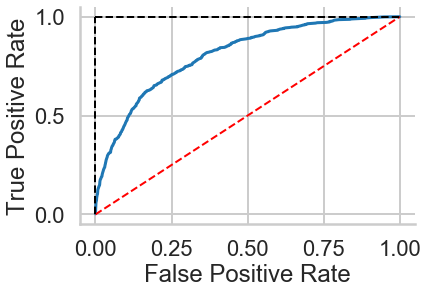

In [12]:
sns.set_style('whitegrid')
sns.set_context('poster')
ax=sns.lineplot(x=fpr, y=tpr)
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
sns.despine()
plt.plot([0, 1], [0, 1], linewidth=2, linestyle='--', color='red')
plt.plot([0, 0], [0, 1], linewidth=2, linestyle='--', color='black')
plt.plot([0, 1], [1, 1], linewidth=2, linestyle='--', color='black')

In [13]:
#Train the model on all available data for pickling
X = tf_corpus
y = list_labels
X_upsample, y_upsample = sm.fit_resample(X, y)
logreg_full = LogisticRegression(C=.1, penalty='l2', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=13)
logreg_full.fit(X_upsample, y_upsample)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=13, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
filename = 'streamlit_app/trained_model.sav'
pickle.dump(logreg_full, open(filename, 'wb'))